In [1]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch
from torch import nn, optim
from src.utils import set_random_seeds, vec_to_img, get_fmnist_functa
import numpy as np
from src.SIREN import ModulatedSIREN
from classifier import VanillaClassifier
import argparse
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def attack_classifier(model,
                      loader: DataLoader,
                      criterion,
                      linf_bound,
                      num_pgd_steps = 10,
                      device = "cuda"):
    """
    :param model: your trained classifier model
    :param loader: data loader for input to be perturbed
    :param criterion: The loss criteria you wish to maximize in attack

    1. Initialization: setting up perturbations and the optimizer.
    2. Optimization loop (PGD Steps): Iteratively adjusting perturbations to maximize loss.
    3. Projection: ensuring perturbations remain within specified bounds.
    4. Evaluation: assessing the model's accuracy on perturbed inputs.
    """

    model.eval() #Model should be used in evaluation mode - we are not training any model weights.
    all_preds = []
    all_labels = []
    all_perts = []
    prog_bar = tqdm(loader, total=len(loader))
    for vectors, labels in prog_bar:
        vectors, labels = vectors.to(device), labels.to(device)
        perts = torch.zeros_like(vectors) #initialize the perturbation vectors for current iteration
        
        ''' TODO (1): Your perts tensor currently will not be optimized since torch wasn't instructed to track gradients for it - make torch track its gradients. '''
        perts.requires_grad = True

        ''' TODO (2): Initialize your optimizer, you might need to finetune the learn-rate.
        What should be the set of parameters the optimizer will be changing? Hint: NOT model.parameters()!
        '''
        attack_learning_rate = linf_bound/4
        optimizer = optim.RMSprop([perts], lr=attack_learning_rate, alpha=0.99)
        '''Every step here is one PGD iteration (meaning, one attack optimization step) optimizing your perturbations.
        After the loop below is over you'd have all fully-optimized perturbations for the current batch of vectors.'''
        for step in range(num_pgd_steps): 

            preds = model(vectors + perts) #feed currently perturbed data into the model
            ''' TODO (3):  What's written in this line for the loss is almost correct. Change the code to MAXIMIZE the loss'''
            # optimizer minimize the loss and we want to maximize the loos to make the model misclassify
            # minimizing -loss is equivalent to maximizing the loss
            loss = -criterion(preds, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            ''' TODO (4): Perform needed L_inf norm bound projection. The 'torch.clamp' function could be useful.'''
            # applying the L∞ norm constraint
            # ensures that each element of perts remains within the range [-linf_bound, linf_bound]
            # constraint should not influence gradient calculations.
            with torch.no_grad():
                epsilon = 1e-10
                # Manually clamp the perturbations
                perts.clamp_(-linf_bound+epsilon, linf_bound-epsilon)
                
                
                
            assert perts.abs().max().item() <= linf_bound #If this assert fails, you have a mistake in TODO(4) 
            perts = perts.detach().requires_grad_() #Reset gradient tracking - we don't want to track gradients for norm projection.
            
            
        ''' TODO (5): Accumulate predictions and labels to compute final accuracy for the attacked classifier.
        You can compute final predictions by taking the argmax over the softmax of predictions.'''
        with torch.no_grad():
            perturbed_vectors = vectors + perts
            outputs = model(perturbed_vectors)
            # outputs has a shape of (batch_size, num_classes)
            # for determine the predicted class
            _, predicted = torch.max(outputs, dim=1)

            
        # for each batch.
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_perts.extend(perts.detach().cpu().numpy())
    return all_labels, all_preds, all_perts

In [3]:

model_path = 'checkpoints/mlp_final.pt'
batch_size = 1
data_path = '/datasets/functaset'

set_random_seeds(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)    
       
# the same parameters as used during training
hidden_dims = [512, 256, 128]
activations = ["lrelu"] * len(hidden_dims)
p_dropout = 0.1
normalization = "batch"


# Instantiate Classifier Model and load weights
classifier = VanillaClassifier(
    in_features=512,
    num_classes=10,
    hidden_dims=hidden_dims,
    nonlins=activations,
    p_dropout=p_dropout,
    normalization=normalization
).to(device)
saved_state = torch.load(model_path, map_location=device)
classifier.load_state_dict(saved_state['model_state'])

test_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_test.pkl", mode='test',
                                          batch_size=batch_size, num_workers=2)
criterion = nn.CrossEntropyLoss()

linf_bounds = [10**(-i) for i in range(3,7)] + [5*10**(-i) for i in range(3,7)]
print(linf_bounds)
linf_bounds.sort()
print(linf_bounds)
accuracies = []
for bound in linf_bounds:
    print("____________________________________")
    print(f'Attacking with linf_bound={bound}')
    all_labels, all_preds, _ = attack_classifier(classifier, test_functaloader, criterion, bound)
    accuracy = accuracy_score(all_labels, all_preds) * 100
    accuracies.append(accuracy)
    print(f'Accuracy after attack with linf_bound={bound}: {accuracy:.2f}%')
print(accuracies)

cuda
[0.001, 0.0001, 1e-05, 1e-06, 0.005, 0.0005, 5e-05, 4.9999999999999996e-06]
[1e-06, 4.9999999999999996e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005]
____________________________________
Attacking with linf_bound=1e-06


100%|█████████████████████████████████████| 10000/10000 [03:22<00:00, 49.41it/s]


Accuracy after attack with linf_bound=1e-06: 88.92%
____________________________________
Attacking with linf_bound=4.9999999999999996e-06


100%|█████████████████████████████████████| 10000/10000 [03:22<00:00, 49.31it/s]


Accuracy after attack with linf_bound=4.9999999999999996e-06: 87.74%
____________________________________
Attacking with linf_bound=1e-05


100%|█████████████████████████████████████| 10000/10000 [03:26<00:00, 48.37it/s]


Accuracy after attack with linf_bound=1e-05: 86.36%
____________________________________
Attacking with linf_bound=5e-05


100%|█████████████████████████████████████| 10000/10000 [03:28<00:00, 48.00it/s]


Accuracy after attack with linf_bound=5e-05: 69.49%
____________________________________
Attacking with linf_bound=0.0001


100%|█████████████████████████████████████| 10000/10000 [03:32<00:00, 47.03it/s]


Accuracy after attack with linf_bound=0.0001: 45.85%
____________________________________
Attacking with linf_bound=0.0005


100%|█████████████████████████████████████| 10000/10000 [03:17<00:00, 50.66it/s]


Accuracy after attack with linf_bound=0.0005: 0.28%
____________________________________
Attacking with linf_bound=0.001


100%|█████████████████████████████████████| 10000/10000 [03:24<00:00, 48.98it/s]


Accuracy after attack with linf_bound=0.001: 0.05%
____________________________________
Attacking with linf_bound=0.005


100%|█████████████████████████████████████| 10000/10000 [03:17<00:00, 50.55it/s]

Accuracy after attack with linf_bound=0.005: 0.01%
[88.92, 87.74, 86.36, 69.49, 45.85, 0.27999999999999997, 0.05, 0.01]


[88.92, 87.74, 86.36, 69.49, 45.85, 0.27999999999999997, 0.05, 0.01]
[1e-06, 4.9999999999999996e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005]


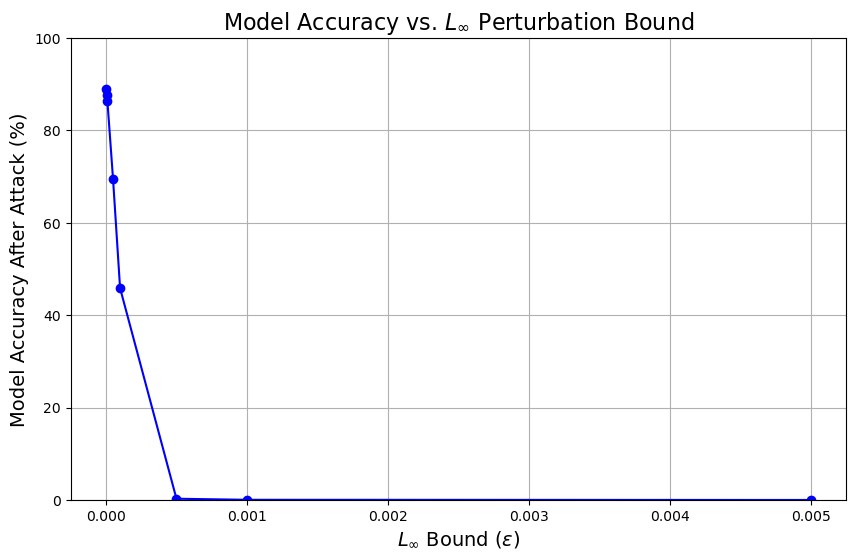

In [4]:
import matplotlib.pyplot as plt

print(accuracies)
print(linf_bounds)
plt.figure(figsize=(10, 6))
plt.plot(linf_bounds, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('$L_{\infty}$ Bound ($\\epsilon$)', fontsize=14)
plt.ylabel('Model Accuracy After Attack (%)', fontsize=14)
plt.title('Model Accuracy vs. $L_{\infty}$ Perturbation Bound', fontsize=16)
plt.ylim(0, 100) 
plt.grid(True)
plt.show()


In [5]:
model_path = 'checkpoints/mlp_final.pt'
batch_size = 1
data_path = '/datasets/functaset'

set_random_seeds(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)    
       
# the same parameters as used during training
hidden_dims = [512, 256, 128]
activations = ["lrelu"] * len(hidden_dims)
p_dropout = 0.1
normalization = "batch"


# Instantiate Classifier Model and load weights
classifier = VanillaClassifier(
    in_features=512,
    num_classes=10,
    hidden_dims=hidden_dims,
    nonlins=activations,
    p_dropout=p_dropout,
    normalization=normalization
).to(device)
saved_state = torch.load(model_path, map_location=device)
classifier.load_state_dict(saved_state['model_state'])

test_functaloader = get_fmnist_functa(data_dir=f"{data_path}/fmnist_test.pkl", mode='test',
                                          batch_size=batch_size, num_workers=2)
criterion = nn.CrossEntropyLoss()


cuda


100%|█████████████████████████████████████| 10000/10000 [03:22<00:00, 49.45it/s]


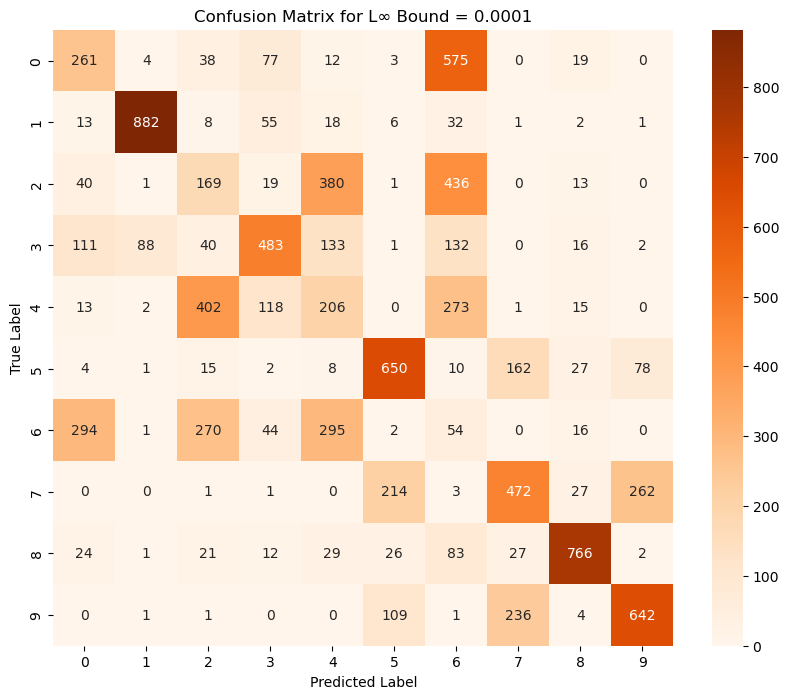

In [6]:
linf_bound = 0.0001

true_labels, pred_labels, perts = attack_classifier(classifier, test_functaloader, criterion, linf_bound)
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for L∞ Bound = {linf_bound}')
plt.show()


In [7]:
from collections import defaultdict
from utils import vec_to_img
import matplotlib.pyplot as plt
from SIREN import ModulatedSIREN
from torch.utils.data import Subset
inr = ModulatedSIREN(height=28, width=28, hidden_features=256, num_layers=10, modul_features=512)
inr.load_state_dict(torch.load(f"{data_path}/modSiren.pth")['state_dict'])
inr = inr.to(device)

mask= np.isin(true_labels, [5,7,9])
indices = np.where(mask)[0]
filtered_true_labels = np.array(true_labels)[indices]
filtered_pred_labels = np.array(pred_labels)[indices]
filtered_perts = np.array(perts)[indices]
dict_bad= defaultdict(int)
dict_good=defaultdict(int)
dataset = test_functaloader.dataset
dataset = Subset(dataset, indices)
chosen = []
for i,label in enumerate(filtered_true_labels):
    if label!=filtered_pred_labels[i] and dict_bad[label]<1:
        sample,_ = dataset[i]
        img_tensor = vec_to_img(inr, sample.to(device)).cpu().detach().numpy()  # Extract image using vec_to_img
        fig, axes = plt.subplots(1, 3, figsize=(10, 10))
        axes[0].imshow(img_tensor, cmap='gray')
        axes[0].set_title(f"Original image: True:{label}, Predicated:{filtered_pred_labels[i]}")
        axes[0].axis('off')
        pert= torch.from_numpy(filtered_perts[i])
        pert_tensor = vec_to_img(inr, pert.to(device)).cpu().detach().numpy()  # Extract image using vec_to_img
        axes[1].imshow(pert_tensor, cmap='gray')
        axes[1].set_title(f"Perturbation: True:{label}, Predicated:{filtered_pred_labels[i]}")
        axes[1].axis('off')
        attack_tensor = vec_to_img(inr, (pert+sample).to(device)).cpu().detach().numpy()  # Extract image using vec_to_img
        axes[2].imshow(attack_tensor, cmap='gray')
        axes[2].set_title(f"Attack image: True:{label}, Predicated:{filtered_pred_labels[i]}")
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()
        dict_bad[label]+=1
        chosen.append(pert)
    if label==filtered_pred_labels[i] and dict_good[label]<1:
        sample,_ = dataset[i]
        img_tensor = vec_to_img(inr, sample.to(device)).cpu().detach().numpy()  # Extract image using vec_to_img
        fig, axes = plt.subplots(1, 3, figsize=(10, 10))
        axes[0].imshow(img_tensor, cmap='gray')
        axes[0].set_title(f"Original image: True:{label}, Predicated:{filtered_pred_labels[i]}")
        axes[0].axis('off')
        pert= torch.from_numpy(filtered_perts[i])
        pert_tensor = vec_to_img(inr, pert.to(device)).cpu().detach().numpy()  # Extract image using vec_to_img
        axes[1].imshow(pert_tensor, cmap='gray')
        axes[1].set_title(f"Perturbation: True:{label}, Predicated:{filtered_pred_labels[i]}")
        axes[1].axis('off')
        attack_tensor = vec_to_img(inr, (pert+sample).to(device)).cpu().detach().numpy()  # Extract image using vec_to_img
        axes[2].imshow(attack_tensor, cmap='gray')
        axes[2].set_title(f"Attack image: True:{label}, Predicated:{filtered_pred_labels[i]}")
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()
        dict_good[label]+=1
        chosen.append(pert)

ModuleNotFoundError: No module named 'utils'

In [ ]:
from collections import defaultdict
from utils import vec_to_img
import matplotlib.pyplot as plt
from SIREN import ModulatedSIREN
from torch.utils.data import Subset
import torch

def plot_images(inr, sample, pert, true_label, pred_label):
    img_tensor = vec_to_img(inr, sample.to(device)).cpu().detach().numpy()  # Original image
    pert_tensor = vec_to_img(inr, pert.to(device)).cpu().detach().numpy()  # Perturbation image
    attack_tensor = vec_to_img(inr, (pert + sample).to(device)).cpu().detach().numpy()  # Attacked image

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    axes[0].imshow(img_tensor, cmap='gray')
    axes[0].set_title(f"Original image: True:{true_label}, Predicted:{pred_label}")
    axes[0].axis('off')

    axes[1].imshow(pert_tensor, cmap='gray')
    axes[1].set_title(f"Perturbation: True:{true_label}, Predicted:{pred_label}")
    axes[1].axis('off')

    axes[2].imshow(attack_tensor, cmap='gray')
    axes[2].set_title(f"Attack image: True:{true_label}, Predicted:{pred_label}")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Load the model
inr = ModulatedSIREN(height=28, width=28, hidden_features=256, num_layers=10, modul_features=512)
inr.load_state_dict(torch.load(f"{data_path}/modSiren.pth")['state_dict'])
inr = inr.to(device)

# Filtering data
mask = np.isin(true_labels, [5, 7, 9])
indices = np.where(mask)[0]
filtered_true_labels = np.array(true_labels)[indices]
filtered_pred_labels = np.array(pred_labels)[indices]
filtered_perts = np.array(perts)[indices]
dict_bad = defaultdict(int)
dict_good = defaultdict(int)
dataset = test_functaloader.dataset
dataset = Subset(dataset, indices)

# Iterate through the filtered labels and predictions
for i, label in enumerate(filtered_true_labels):
    sample, _ = dataset[i]
    pert = torch.from_numpy(filtered_perts[i])

    if label != filtered_pred_labels[i] and dict_bad[label] < 1:
        # Plot misclassified image (bad case)
        plot_images(inr, sample, pert, label, filtered_pred_labels[i])
        dict_bad[label] += 1
       
    
    if label == filtered_pred_labels[i] and dict_good[label] < 1:
        # Plot correctly classified image (good case)
        plot_images(inr, sample, pert, label, filtered_pred_labels[i])
        dict_good[label] += 1
